# K-Means Clustering

## Assignment 1 (2 scores):

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of intializing centroids randomly to the overall performance of K-means.

### Import thư viện

In [20]:
import numpy as np
import matplotlib.pyplot as plt # chỉ dùng để trực quan hóa kết quả

### Tạo toy dataset

In [21]:
np.random.seed(42)

# Setup
n_per_cluster = 200
K = 3
Sigma = np.array([[1.0, 0.0],
                  [0.0, 1.0]])

means = np.array([
    [2.0, 2.0],
    [8.0, 3.0],
    [3.0, 6.0]
])

# Generate data
X_list = []
for mu in means:
    X_list.append(np.random.multivariate_normal(mean=mu, cov=Sigma, size=n_per_cluster))
X = np.vstack(X_list) 

# Shuffle dataset
perm = np.random.permutation(X.shape[0])
X = X[perm]

print("X shape:", X.shape)
print("First 10 points:\n", X[:5])

X shape: (600, 2)
First 10 points:
 [[2.22409248 2.0125924 ]
 [2.9803622  6.55248995]
 [1.18177932 4.09238728]
 [3.78580016 6.42545756]
 [7.75103585 3.97157095]]


### Chuẩn bị các hàm cho KMeans

In [22]:
def kmeans_init_centroids(X, k, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    idx = rng.choice(X.shape[0], size=k, replace=False)
    return X[idx].copy()

def kmeans_assign_labels(X, centroids): 
    d2 = ((X[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
    labels = np.argmin(d2, axis=1)
    return labels

def kmeans_update_centroids(X, labels, K, rng=None): 
    if rng is None:
        rng = np.random.default_rng()

    new_centroids = np.zeros((K, X.shape[1]), dtype=float)
    for k in range(K):
        mask = (labels == k)
        if np.any(mask):
            new_centroids[k] = X[mask].mean(axis=0)
        else:
            new_centroids[k] = X[rng.integers(0, X.shape[0])]
    return new_centroids

def has_converged(centroids, new_centroids, tol=1e-6):
    return np.max(np.linalg.norm(new_centroids - centroids, axis=1)) < tol

def kmeans_inertia(X, centroids, labels):
    return ((X - centroids[labels]) ** 2).sum()


### Phần chính của K-means Clustering

In [23]:
def kmeans(X, K, max_iters=100, tol=1e-6, seed=0):
    rng = np.random.default_rng(seed)
    centroids = kmeans_init_centroids(X, K, rng=rng)

    centroids_hist = [centroids.copy()]
    labels_hist = []
    inertia_hist = []

    for it in range(1, max_iters + 1):
        # E-step
        labels = kmeans_assign_labels(X, centroids)

        inertia = kmeans_inertia(X, centroids, labels)
        labels_hist.append(labels.copy())
        inertia_hist.append(float(inertia))

        # M-step
        new_centroids = kmeans_update_centroids(X, labels, K, rng=rng)

        centroids_hist.append(new_centroids.copy())

        if has_converged(centroids, new_centroids, tol=tol):
            return centroids_hist, labels_hist, it, inertia_hist

        centroids = new_centroids

    return centroids_hist, labels_hist, max_iters, inertia_hist


### Hàm trực quan hóa kết quả

In [26]:
def kmeans_display(X, labels, centroids=None, title="K-means result"):
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=18)
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker="X")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True, alpha=0.25)
    plt.show()

def plot_inertia(inertia_hist, title="Inertia vs iteration"):
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(1, len(inertia_hist) + 1), inertia_hist, marker="o")
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Inertia")
    plt.grid(True, alpha=0.25)
    plt.show()


### Áp dụng thuật toán K-means vào dữ liệu

Iterations: 4
Centers found by our algorithm:
 [[2.02113913 2.01991804]
 [3.19050849 6.10167164]
 [7.93924027 2.98407134]]


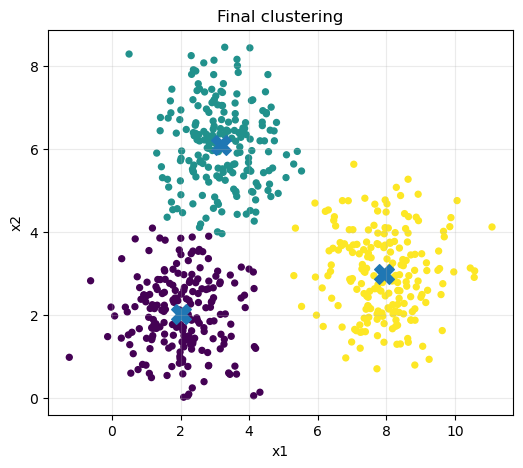

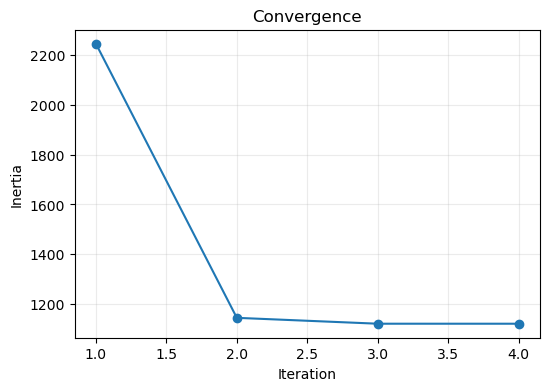

In [27]:
K = 3
centroids_hist, labels_hist, it, inertia_hist = kmeans(X, K, max_iters=100, tol=1e-6, seed=42)

print("Iterations:", it)
print("Centers found by our algorithm:\n", centroids_hist[-1])

kmeans_display(X, labels_hist[-1], centroids=centroids_hist[-1], title="Final clustering")
plot_inertia(inertia_hist, title="Convergence")


### Hiển thị kết quả sau mỗi vòng lặp

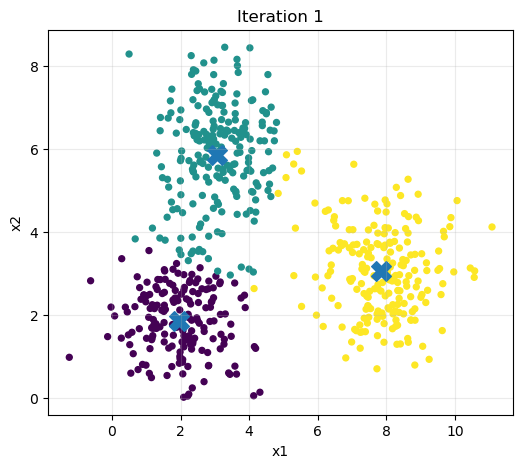

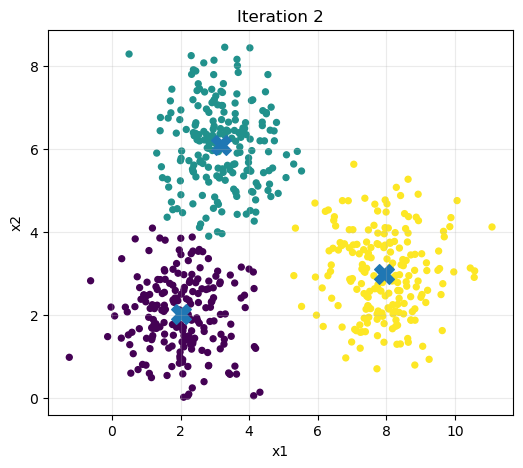

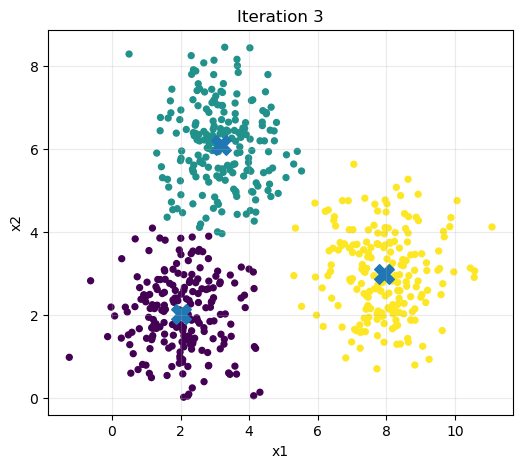

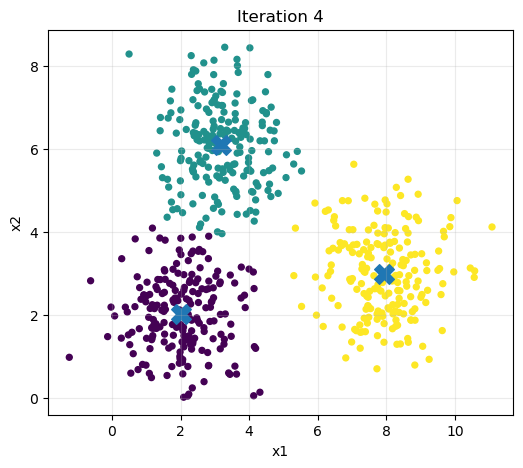

In [28]:
show_iters = list(range(1, min(6, len(labels_hist) + 1)))  
if len(labels_hist) > 6:
    show_iters += [len(labels_hist)]  

for t in show_iters:
    kmeans_display(
        X,
        labels_hist[t-1],
        centroids=centroids_hist[t],
        title=f"Iteration {t}"
    )

### Voronoi

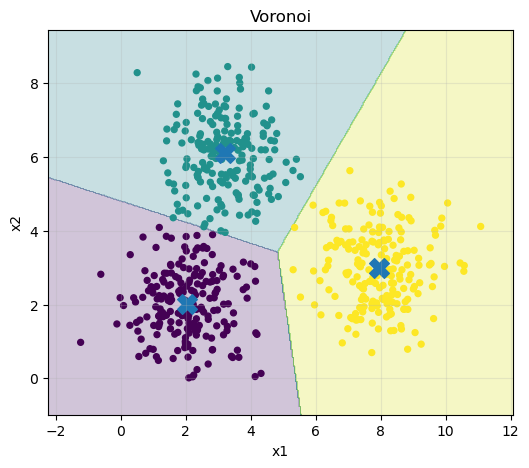

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_voronoi_2d(X, centroids, title="Voronoi"):
    pad = 1.0
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    n = 400
    xs = np.linspace(x_min, x_max, n)
    ys = np.linspace(y_min, y_max, n)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.c_[xx.ravel(), yy.ravel()] 

    d2 = ((grid[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
    zz = np.argmin(d2, axis=1).reshape(n, n)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, zz, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=labels_hist[-1], s=18)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker="X")
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.grid(True, alpha=0.25)
    plt.show()

plot_voronoi_2d(X, centroids_hist[-1])

### Nhận xét về ảnh hưởng của việc khởi tạo ngẫu nhiên trong K-means

Trong K-means, các centroid ban đầu thường được chọn ngẫu nhiên từ dữ liệu. Nếu các centroid này nằm gần trung tâm tự nhiên của các cụm, thuật toán sẽ nhanh chóng phân cụm đúng. Ngược lại, nếu chọn không tốt, kết quả phân cụm có thể kém chất lượng.

Với cùng một tập dữ liệu nhưng khởi tạo centroid khác nhau, K-means có thể hội tụ đến các cụm khác nhau và cho ra các vị trí centroid khác nhau. Tuy nhiên, nếu dữ liệu cân bằng thì việc này ít ảnh hưởng đến chất lượng của kết quả.

Khởi tạo ngẫu nhiên còn ảnh hưởng đến tốc độ hội tụ:
- Khởi tạo tốt → thuật toán hội tụ nhanh, ít vòng lặp
- Khởi tạo kém → cần nhiều vòng lặp hơn để ổn định

Ngoài ra, khởi tạo ngẫu nhiên có thể xuất hiện phân cụm không mong muốn.
Trong một số trường hợp, hai centroid ban đầu nằm gần nhau cùng chiếm một cụm dữ liệu có thể khiến một cụm khác bị chia nhỏ hoặc gộp sai và dẫn đến phân cụm không phản ánh đúng cấu trúc thật của dữ liệu.

### Thử lại với Scikit-learn

Centers found by scikit-learn:
 [[2.02113913 2.01991804]
 [7.93924027 2.98407134]
 [3.19050849 6.10167164]]


c:\Users\ASUS\miniconda3\envs\AIO_basic\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


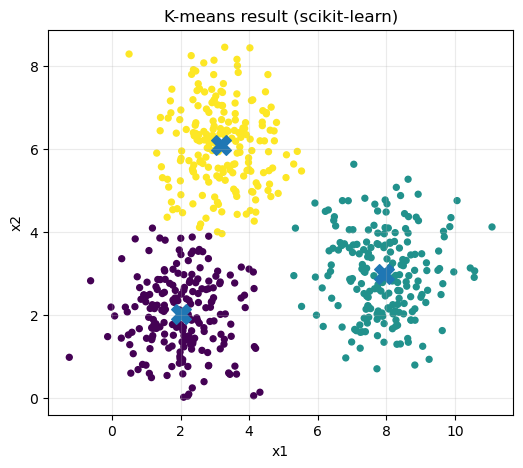

In [30]:
from sklearn.cluster import KMeans

kmeans_sklearn = KMeans(
    n_clusters=K,
    init="random",     
    n_init=10,          
    random_state=42
)

labels_skl = kmeans_sklearn.fit_predict(X)
centroids_skl = kmeans_sklearn.cluster_centers_

print("Centers found by scikit-learn:\n", centroids_skl)

kmeans_display(
    X,
    labels_skl,
    centroids=centroids_skl,
    title="K-means result (scikit-learn)"
)

Ta thấy kết quả cũng tương tự như code chay. 

## Assignment 2 (2 scores):
- Generate a toy dataset having $50$ points following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $20$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $1000$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of different sizes among clusters to the performance of K-means.

### Import thư viện

In [31]:
import numpy as np
import matplotlib.pyplot as plt # chỉ dùng để trực quan hóa kết quả

### Tạo toy dataset

In [33]:
np.random.seed(42)

Sigma = np.array([[1.0, 0.0],
                  [0.0, 1.0]])

mu1 = np.array([2.0, 2.0])
mu2 = np.array([8.0, 3.0])
mu3 = np.array([3.0, 6.0])

X1 = np.random.multivariate_normal(mu1, Sigma, size=50)
X2 = np.random.multivariate_normal(mu2, Sigma, size=20)
X3 = np.random.multivariate_normal(mu3, Sigma, size=1000)

X = np.vstack([X1, X2, X3])

X = X[np.random.permutation(X.shape[0])]

print("Dataset shape:", X.shape)

Dataset shape: (1070, 2)


### Chuẩn bị các hàm cho KMeans

In [34]:
# Đã cài ở bài 1

### Áp dụng thuật toán K-means vào dữ liệu

Iterations: 31
Final centroids:
 [[2.6058088  6.57202435]
 [2.04353835 3.38376856]
 [4.07550659 5.47417485]]


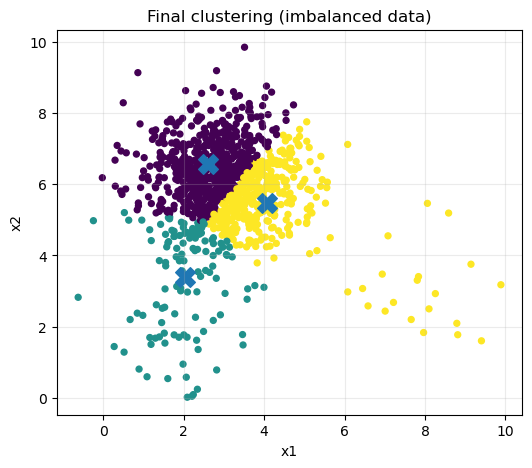

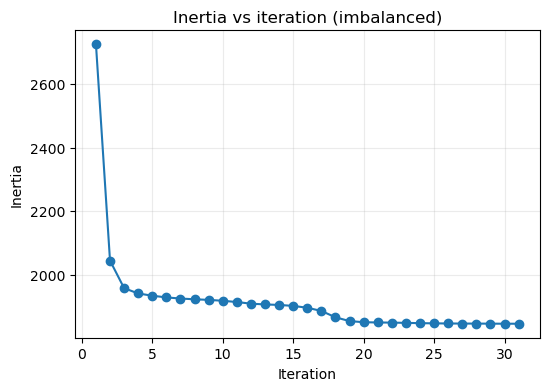

In [35]:
K = 3

centroids_hist, labels_hist, it, inertia_hist = kmeans(
    X, K, max_iters=100, tol=1e-6, seed=42
)

print("Iterations:", it)
print("Final centroids:\n", centroids_hist[-1])

kmeans_display(
    X,
    labels_hist[-1],
    centroids=centroids_hist[-1],
    title="Final clustering (imbalanced data)"
)

plot_inertia(inertia_hist, title="Inertia vs iteration (imbalanced)")


### Hiển thị kết quả sau mỗi vòng lặp

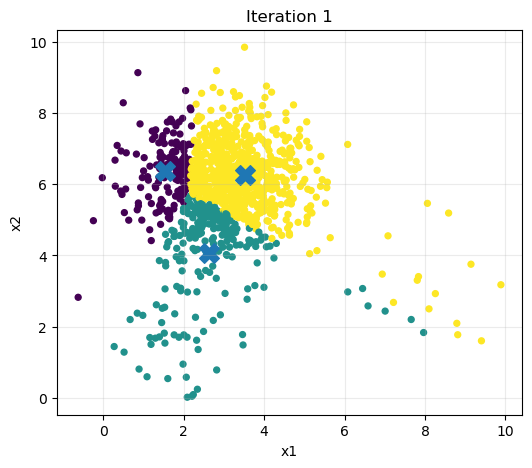

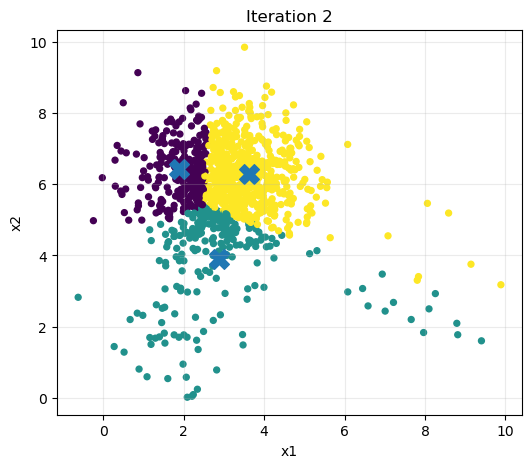

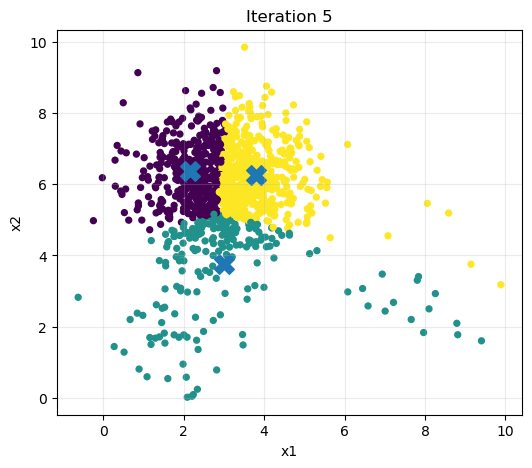

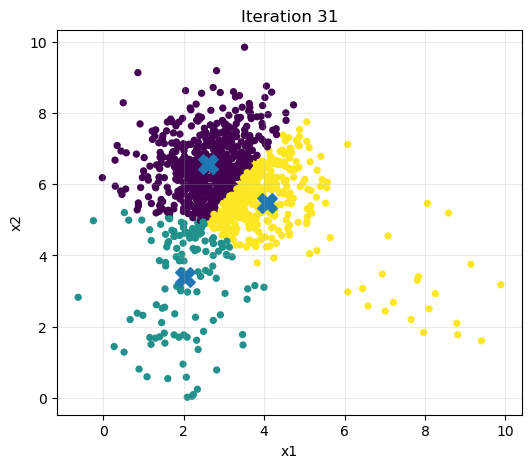

In [36]:
show_iters = [1, 2, 5, len(labels_hist)]

for t in show_iters:
    kmeans_display(
        X,
        labels_hist[t-1],
        centroids=centroids_hist[t],
        title=f"Iteration {t}"
    )

### Voronoi

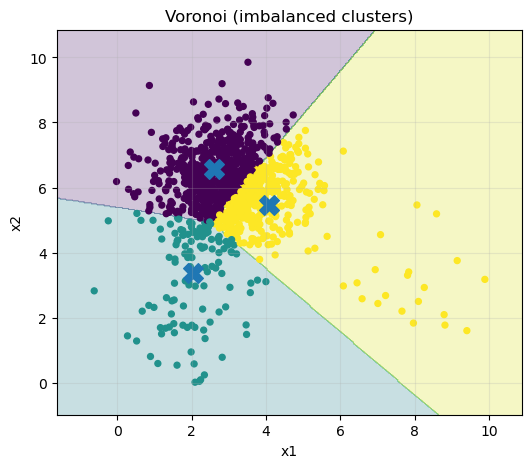

In [38]:
plot_voronoi_2d(
    X,
    centroids_hist[-1],
    title="Voronoi (imbalanced clusters)"
)

### Nhận xét về ảnh hưởng của kích thước cụm khác nhau đến K-means

- K-means có xu hướng ưu tiên các cụm lớn vì số lượng điểm trong cụm lớn chiếm ưu thế, vị trí centroid thường bị kéo về phía cụm có nhiều điểm hơn.

- Các cụm nhỏ dễ bị "nuốt" hoặc gộp sai vì khi một cụm có rất ít điểm (ví dụ 20 điểm), centroid của nó có thể bị kéo về cụm lớn gần nhất hoặc biến mất nếu khởi tạo không tốt

- Việc mất cân bằng kích thước cụm khiến tốc độ hội tụ không ổn định. Một số lần chạy hội tụ nhanh nhưng một số lần cần nhiều vòng lặp hơn để tách cụm nhỏ ra khỏi cụm lớn.

Từ đó, ta nhận thấy hạn chế của K-means trong dữ liệu thực tế là: K-means giả định các cụm có kích thước và mật độ tương tự nhau. Khi giả định này bị vi phạm chất lượng phân cụm có thể giảm rõ rệt.

### Thử lại với scikit-learn

c:\Users\ASUS\miniconda3\envs\AIO_basic\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


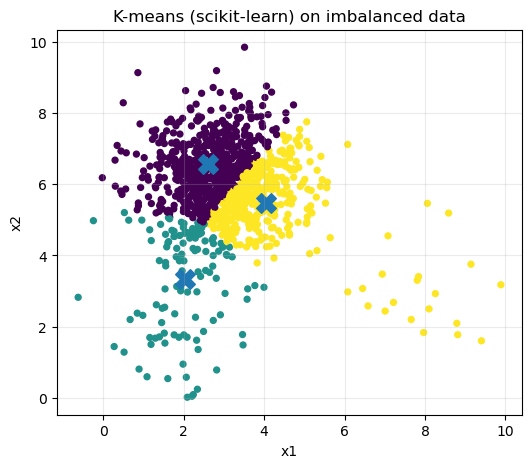

In [40]:
from sklearn.cluster import KMeans

kmeans_skl = KMeans(
    n_clusters=K,
    init="random",
    n_init=10,
    random_state=42
)

labels_skl = kmeans_skl.fit_predict(X)

kmeans_display(
    X,
    labels_skl,
    centroids=kmeans_skl.cluster_centers_,
    title="K-means (scikit-learn) on imbalanced data"
)

Kết quả tương tự như khi code chay

## Assignment 3 (2 scores):

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma_1)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma_1)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma_2)$ where 

$$
    \Sigma_1 = 
    \left(\begin{array}{cc}
        1 & 0 \\
        0 & 1
    \end{array}\right)
$$ 

and

$$
\Sigma_2 = 
    \left(\begin{array}{cc}
        10 & 0 \\
        0 & 1
    \end{array}\right)
$$.

- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the performance of K-means.

### Import thư viện

In [42]:
import numpy as np
import matplotlib.pyplot as plt # chỉ dùng để trực quan hóa kết quả

### Tạo toy dataset

In [44]:
np.random.seed(42)

mu1 = np.array([2.0, 2.0])
mu2 = np.array([8.0, 3.0])
mu3 = np.array([3.0, 6.0])

Sigma1 = np.array([[1.0, 0.0],
                   [0.0, 1.0]])

Sigma2 = np.array([[10.0, 0.0],
                   [0.0, 1.0]])  

n = 200

X1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
X2 = np.random.multivariate_normal(mu2, Sigma1, size=n)
X3 = np.random.multivariate_normal(mu3, Sigma2, size=n)

X = np.vstack([X1, X2, X3])
X = X[np.random.permutation(X.shape[0])] 

print("Dataset shape:", X.shape)

Dataset shape: (600, 2)


### Trực quan hóa dataset ban đầu

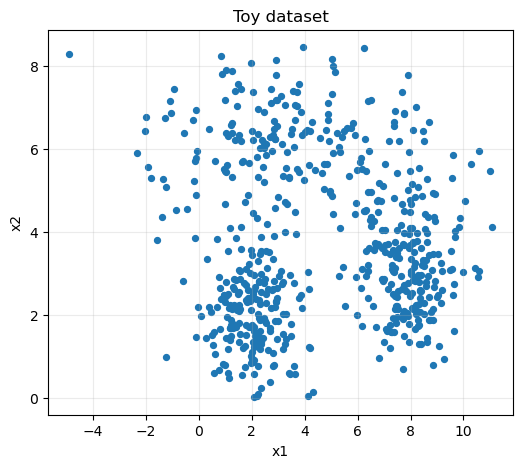

In [46]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], s=18)
plt.title("Toy dataset")
plt.xlabel("x1"); plt.ylabel("x2")
plt.grid(True, alpha=0.25)
plt.show()

Ta thấy cụm Σ2 bị kéo dài theo trục x và phân tán rất rộng

### Chuẩn bị các hàm cho KMeans

In [47]:
## Sử dụng lại của câu 1

### Áp dụng thuật toán K-means vào dữ liệu

Iterations: 6
Final centroids:
 [[1.96713809 2.05011551]
 [2.44220016 6.25733703]
 [7.82773082 3.52419383]]


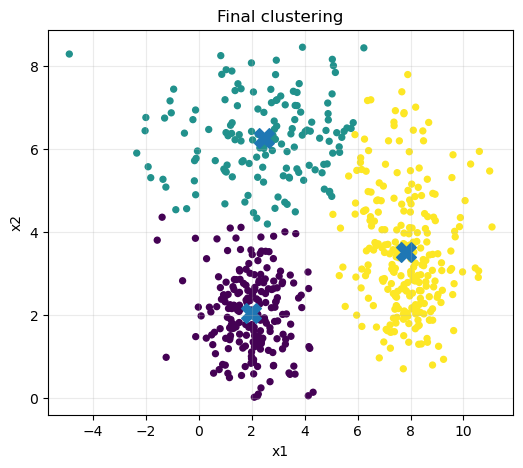

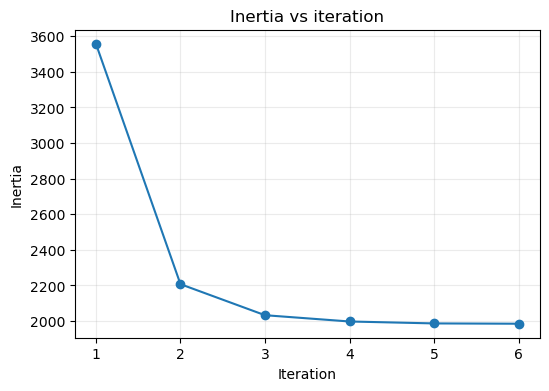

In [48]:
K = 3

centroids_hist, labels_hist, it, inertia_hist = kmeans(
    X, K, max_iters=100, tol=1e-6, seed=42
)

print("Iterations:", it)
print("Final centroids:\n", centroids_hist[-1])

kmeans_display(
    X,
    labels_hist[-1],
    centroids=centroids_hist[-1],
    title="Final clustering"
)

plot_inertia(inertia_hist, title="Inertia vs iteration")


### Hiển thị kết quả sau mỗi vòng lặp

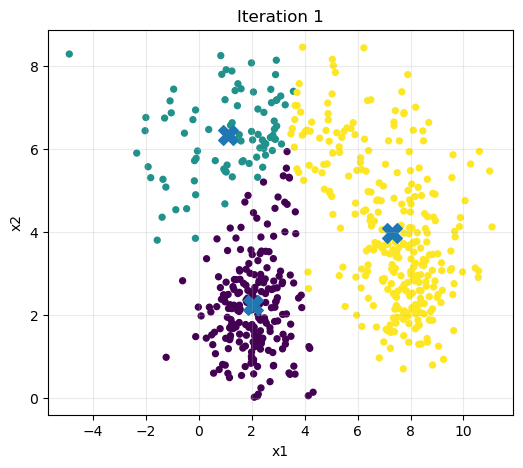

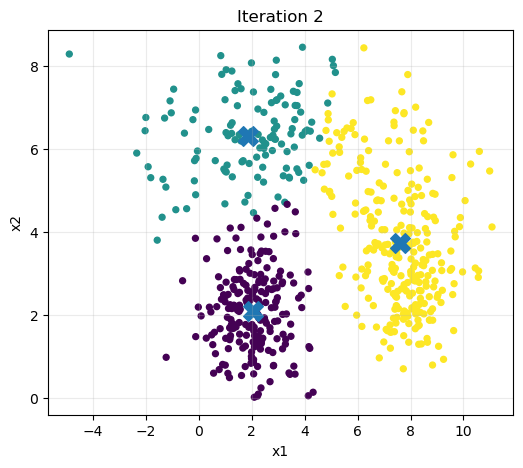

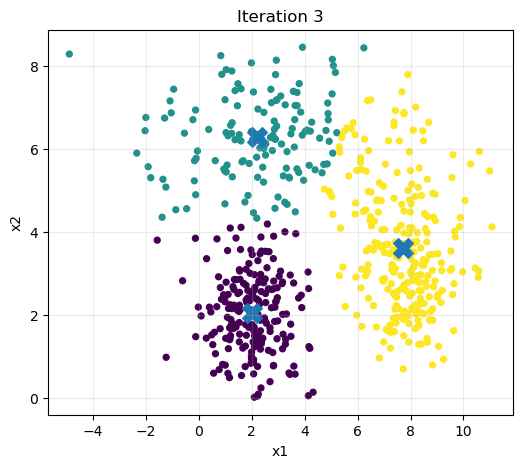

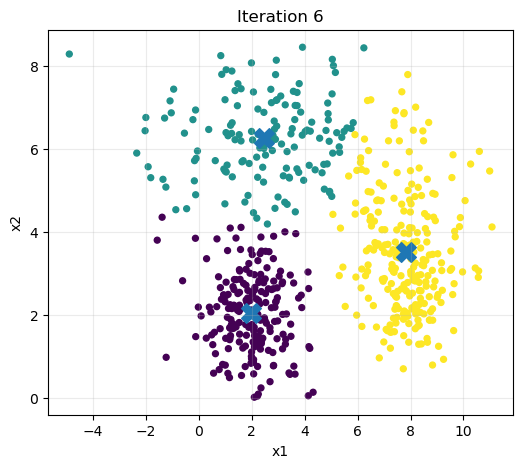

In [50]:
show_iters = [1, 2, 3, len(labels_hist)]

for t in show_iters:
    kmeans_display(
        X,
        labels_hist[t-1],
        centroids=centroids_hist[t],
        title=f"Iteration {t}"
    )

### Voronoi

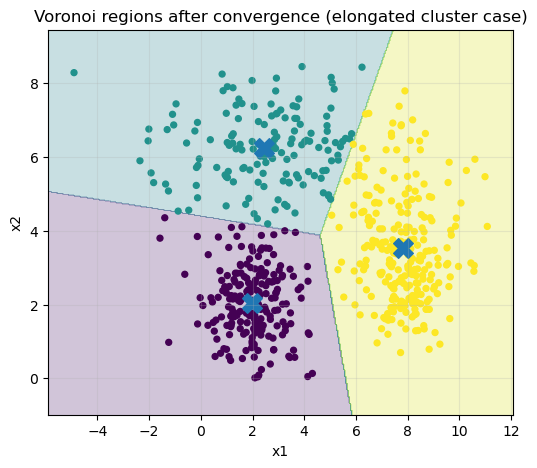

In [51]:
plot_voronoi_2d(
    X,
    centroids_hist[-1],
    title="Voronoi regions after convergence (elongated cluster case)"
)

### Nhận xét về ảnh hưởng của phân phối N((3,6), Σ2) đến K-means

- Cụm Σ2 này có phương sai theo trục x lớn hơn nên dữ liệu phân tán bị kéo dài theo chiều ngang làm cho hình dạng cụm không còn tròn như hai cụm Σ1 còn lại.

- K-means dựa trên khoảng cách Euclid và giả định các cụm có dạng gần “tròn/đều”, nên với một cụm bị kéo dài K-means dễ chia cụm kéo dài thành nhiều phần hoặc làm biên phân cụm bị lệch, kéo theo việc gán nhãn sai ở vùng chồng lấn.

- Do cụm kéo dài có thể trải rộng sang vùng gần các cụm khác nên một số điểm ở đuôi của cụm Σ2 có thể bị gán nhầm sang cụm lân cận.

- Kết quả phụ thuộc nhiều hơn vào khởi tạo ban đầu vì K-means có thể đặt 2 centroid vào cụm kéo dài và làm một cụm còn lại bị thiếu đại diện trong các vòng đầu.

Từ đó ta thấy rằng: K-means hoạt động tốt nhất khi các cụm có kích thước và hình dạng tương tự. Khi có cụm kéo dài như Σ2, chất lượng phân cụm thường giảm.

### Thử lại với scikit-learn

Centers found by scikit-learn:
 [[1.96713809 2.05011551]
 [7.82773082 3.52419383]
 [2.44220016 6.25733703]]


c:\Users\ASUS\miniconda3\envs\AIO_basic\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


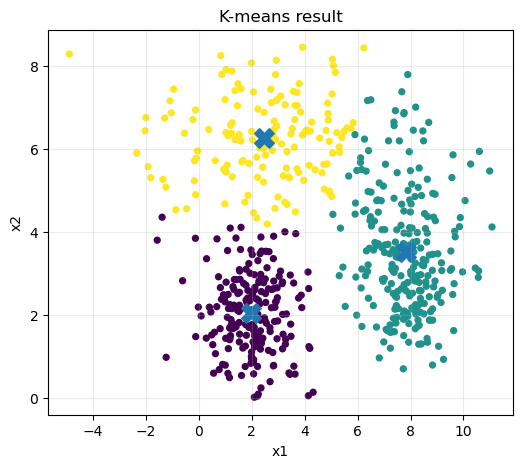

In [54]:
from sklearn.cluster import KMeans

K = 3

kmeans_skl = KMeans(
    n_clusters=K,
    init="random",   
    n_init=10,       
    random_state=42
)

labels_skl = kmeans_skl.fit_predict(X)
centroids_skl = kmeans_skl.cluster_centers_

print("Centers found by scikit-learn:\n", centroids_skl)

kmeans_display(
    X,
    labels_skl,
    centroids=centroids_skl,
    title="K-means result"
)


----

**[ Phần dưới giảm tải ]**

## Gaussian Mixture Model

### Assignment 1 (2 scores):
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

### Assignment 2 (2 scores):

Use the Gaussian Mixture Model to filter out background of a given image.